In [3]:
#предварительная обработка данных

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../dataset/WineDataset.csv')


#обработка отсутствующих значений
def prepro_data(data, targer_col='Wine'):
    data_filled = data.fillna(data.mean())
    #кодируем категориальную переменную(по одному признаку)
    one_hot_df = pd.get_dummies(data_filled, columns=[targer_col], prefix=targer_col)
    #проводим стандартизацию данных
    scaler = StandardScaler()
    stand_data = pd.DataFrame(scaler.fit_transform(one_hot_df), columns=one_hot_df.columns)

    stand_data[targer_col] = data[targer_col]
    return stand_data


stand_data = prepro_data(data)

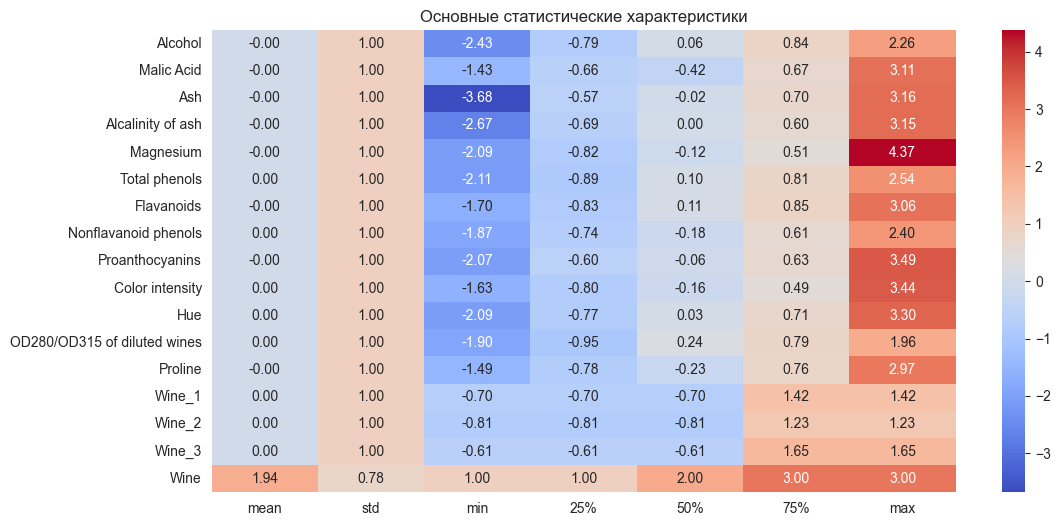

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns


def VIZUAL_STAT(data):
    statistics = data.describe()
    plt.figure(figsize=(12, 6))
    sns.heatmap(statistics.iloc[1:, :].T, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Основные статистические характеристики')
    plt.show()


VIZUAL_STAT(stand_data)

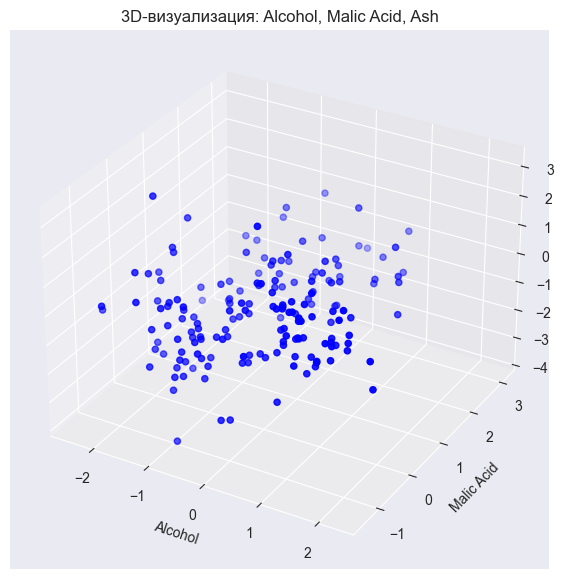

In [28]:
def VIZUAL_3D(data, x_col, y_col, z_col):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[x_col], data[y_col], data[z_col], c='blue', marker='o')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title(f'3D-визуализация: {x_col}, {y_col}, {z_col}')
    plt.show()


VIZUAL_3D(stand_data, 'Alcohol', 'Malic Acid', 'Ash')

In [29]:
import numpy as np
from collections import Counter


#евклидово расстояние ʕʘ‿ಠʔ 
def euc_dist(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))


def knn(train_data, test_row, k):
    distances = [(train_row, euc_dist(test_row[:-1], train_row[:-1])) for _, train_row in train_data.iterrows()]
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    classes = [neighbor[0].iloc[-1] for neighbor in neighbors]
    majority_class = Counter(classes).most_common(1)[0][0]
    return majority_class


In [30]:
import random
from sklearn.metrics import confusion_matrix, accuracy_score


#обучающая и тестовая выборки
def train_test(data, test_size=0.2):
    shuf_data = data.sample(frac=1).reset_index(drop=True)
    train_size = int((1 - test_size) * len(data))
    return shuf_data.iloc[:train_size], shuf_data.iloc[train_size:]


#оценка модели для k
def evaluate_knn(data, k_values, features, target='Wine'):
    selected_data = data[features + [target]]
    train_data, test_data = train_test(selected_data)

    all_predict = {k: [] for k in k_values}
    y_true = test_data[target]

    for k in k_values:
        predict = [knn(train_data, test_row, k) for _, test_row in test_data.iterrows()]
        all_predict[k] = predict
        accuracy = accuracy_score(y_true, predict)
        print(f'k = {k}, Точность = {accuracy:.2f}')

    return all_predict, y_true

In [32]:
# матрица ошибок
def plot_matrix(y_true, all_predict, k_values, title_prefix):
    fig, axes = plt.subplots(1, len(k_values), figsize=(5 * len(k_values), 5))

    for i, k in enumerate(k_values):
        cm = confusion_matrix(y_true, all_predict[k])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=axes[i])
        axes[i].set_title(f'{title_prefix} k = {k}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

Случайные признаки: ['Ash', 'Proanthocyanins', 'Alcohol', 'Total phenols', 'Wine_2']
k = 3, Точность = 0.97
k = 5, Точность = 1.00
k = 7, Точность = 1.00


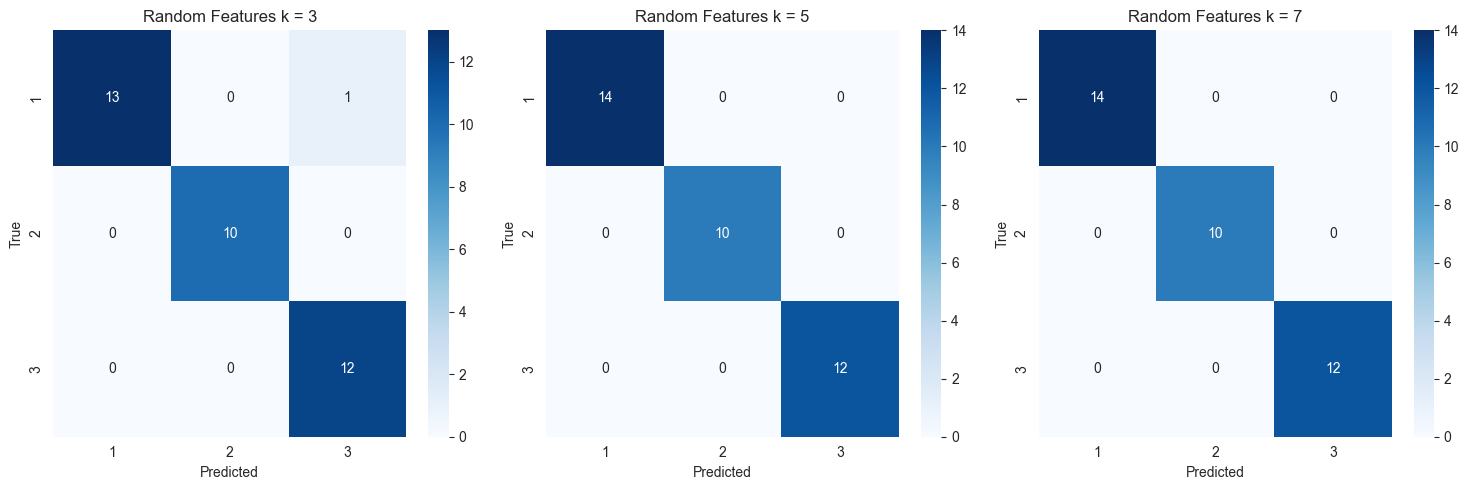

In [33]:
# Модель 1: случайные признаки
random_features = random.sample(list(stand_data.columns[:-1]), 5)
print(f"Случайные признаки: {random_features}")
k_values = [3, 5, 7]
all_predict, y_true = evaluate_knn(stand_data, k_values, random_features)
plot_matrix(y_true, all_predict, k_values, title_prefix='Random Features')

Фиксированные признаки: ['Alcohol', 'Ash', 'Color intensity', 'Proline']
k = 3, Точность = 0.94
k = 5, Точность = 0.94
k = 7, Точность = 0.94


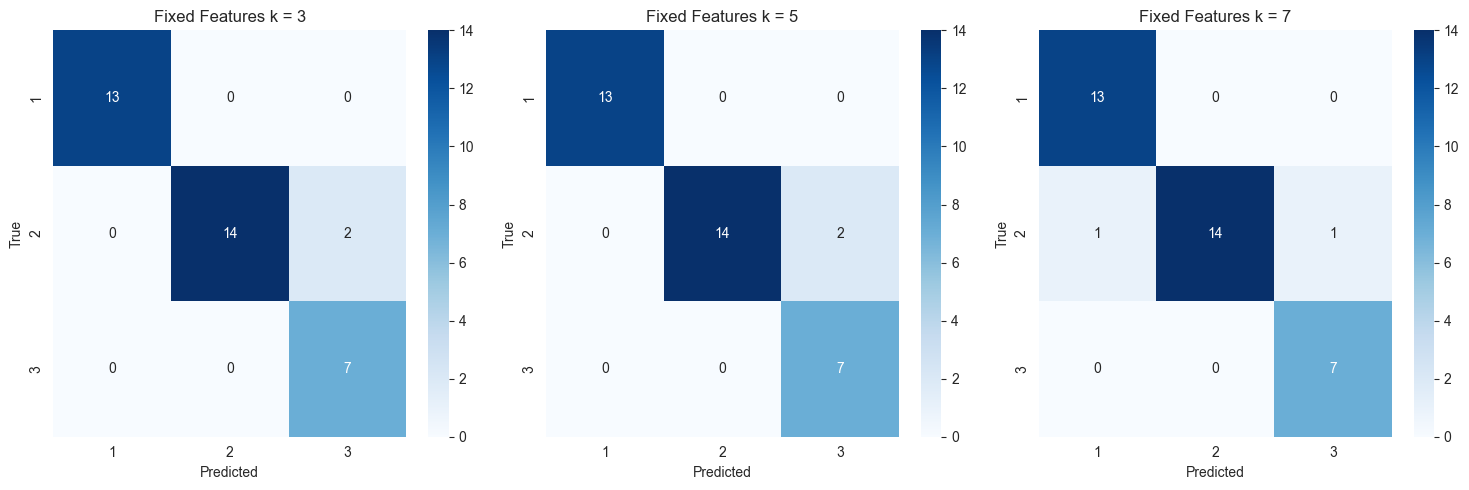

In [34]:
# Модель 2: фиксированный набор признаков
fixed_features = ['Alcohol', 'Ash', 'Color intensity', 'Proline']
print(f"Фиксированные признаки: {fixed_features}")
all_predict, y_true = evaluate_knn(stand_data, k_values, fixed_features)

# Построение матрицы ошибок
plot_matrix(y_true, all_predict, k_values, title_prefix='Fixed Features')